In [77]:
# Look for possible beacons using Zeek data
from ssh2.session import Session
import socket

class SSHCommand:
    address = ""
    username = ""
    password = ""
    
    def __init__(self, address="127.0.0.1", username="none", password="none"):
        self.address = address
        self.username = username
        self.password = password
    
    def execute(self, command = ""):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((self.address, 22))
        session = Session()
        session.handshake(sock)
        session.userauth_password(self.username, self.password)
        channel = session.open_session()
        channel.execute(command)
        result = ""
        size, result = channel.read()
        while size > 0:
            size, data = channel.read()
            result = result + data
        channel.close()
        session.disconnect()
        return result.decode('ascii')


In [78]:
ssh = SSHCommand(address='192.168.1.10', username='admin', password='password')
result = ssh.execute('echo -e \"timestamp,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts\" && zcat /nsm/zeek/logs/2022-08-17//conn.* | jq -j \'select(.conn_state == \"SF\") | .[\"ts\"], \",\", .[\"duration\"], \",\", .[\"orig_bytes\"], \",\", .[\"resp_bytes\"], \",\", .[\"orig_pkts\"], \",\", .[\"resp_pkts\"], \"\n\"\' | awk -F \":\" \'{print $1,$3}\'')

In [79]:
from io import StringIO
import pandas as pd

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

df = string_to_df(result)
all_pkts = df['orig_pkts'] + df['resp_pkts']
all_bytes = df['orig_bytes'] + df['resp_bytes']
df["all_pkts"] = all_pkts
df["all_bytes"] = all_bytes
df['date'] = pd.to_datetime(df['timestamp'],unit='s')
df

,timestamp,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts,all_pkts,all_bytes,date
0,1.660694e+09,2.039075,50.0,114.0,1,1,2,164.0,2022-08-17 00:00:02.372251904
1,1.660694e+09,4.064150,93.0,243.0,2,2,4,336.0,2022-08-17 00:00:02.300108032
2,1.660694e+09,2.038839,50.0,105.0,1,1,2,155.0,2022-08-17 00:00:02.372555008
3,1.660694e+09,4.068380,93.0,243.0,2,2,4,336.0,2022-08-17 00:00:06.365487104
4,1.660694e+09,2.034879,50.0,114.0,1,1,2,164.0,2022-08-17 00:00:44.372294912
...,...,...,...,...,...,...,...,...,...
16052,1.660781e+09,74.195386,23700.0,27619.0,214,130,344,51319.0,2022-08-17 23:57:50.560344832
16053,1.660781e+09,5.396579,2290.0,2573.0,24,17,41,4863.0,2022-08-17 23:58:59.359493888
16054,1.660781e+09,91.754582,35393.0,107219.0,157,116,273,142612.0,2022-08-17 23:57:32.973409792
16055,1.660781e+09,61.649581,683528.0,1656085.0,3244,3073,6317,2339613.0,2022-08-17 23:58:03.106742016


In [107]:
# Don't run this cell until fixed. Tryining to get date/time to 1 hour increments

from io import StringIO
import pandas as pd
import datetime

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

ts2 = df['timestamp'].iloc[0] # Get the first timestamp of the log

test = "ts,all_pkts_hour,all_bytes_hour\n"
ts_index = 0
pkts_index = 0
all_pkts_hour = 0
all_bytes_hour = 0
df_pkts = pd.DataFrame(columns=["ts","all_pkts_hour","all_bytes_hour"])
for index,value in df['timestamp'].sort_values().items():
    ts1 = value
    ts_count = value
    if ts_count >= ts2 + 10: # if the value of the current timestamp is 3600 seconds (1 hour) equal to or greater than the previous timestamp
        all_pkts_hour = all_pkts_hour + df['all_pkts'].iloc[index] # get total packet count for this index
        all_bytes_hour = all_bytes_hour + df['all_bytes'].iloc[index]
        epoch_time = ts1
        datetime_time = datetime.datetime.fromtimestamp(epoch_time) # create ISO date from epoch_time
        test += str(datetime_time) + ',' + str(all_pkts_hour) + ',' + str(all_bytes_hour) + '\n' #build list for pandas array
        all_pkts_hour = 0
        all_bytes_hour = 0
        ts2 = value
    else: # else if the current timestamp is less than 3600 seconds than the previous timestamp
        all_pkts_hour = all_pkts_hour + df['all_pkts'].iloc[index] #increment origpkts
        all_bytes_hour = all_bytes_hour + df['all_bytes'].iloc[index] # increment respPkts

df_pkts = pd.read_csv(StringIO(str(test)), sep=",")


<AxesSubplot:xlabel='ts'>

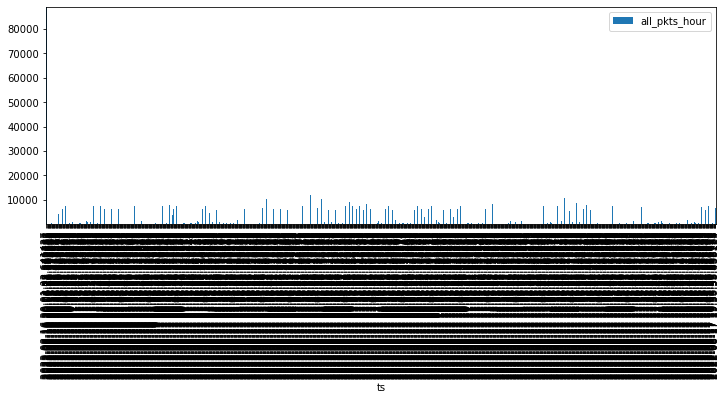

In [96]:
# Only run the following when checking the ts_count value againest an hourly rate (ts2 + 3600) in the previous cell
MAX_Y =  (df_pkts.loc[:, 'all_pkts_hour']).max()
df_pkts.plot(x="ts", y="all_pkts_hour", kind="bar", figsize=(12,4), ylim=(0.1,MAX_Y))

<AxesSubplot:xlabel='ts'>

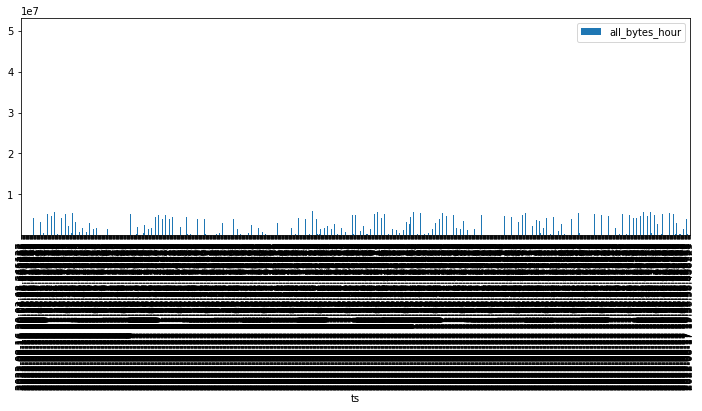

In [97]:
# Only run the following when checking the ts_count value againest an hourly rate (ts2 + 3600) in the previous cell
MAX_Y =  (df_pkts.loc[:, 'all_bytes_hour']).max()
df_pkts.plot(x="ts", y="all_bytes_hour", kind="bar", figsize=(12,4), ylim=(0.1,MAX_Y))

<AxesSubplot:xlabel='ts', ylabel='all_pkts_hour'>

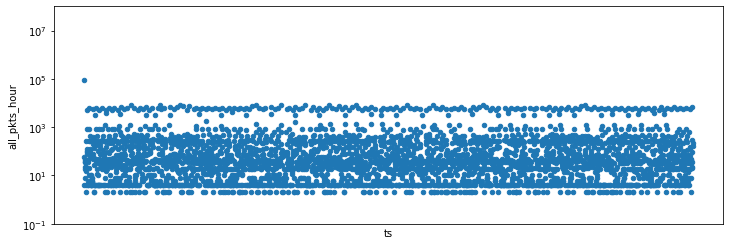

In [108]:
df_pkts.plot(x="ts", y="all_pkts_hour", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4), ylim=(0.1,1*100000000))

<AxesSubplot:xlabel='ts', ylabel='all_bytes_hour'>

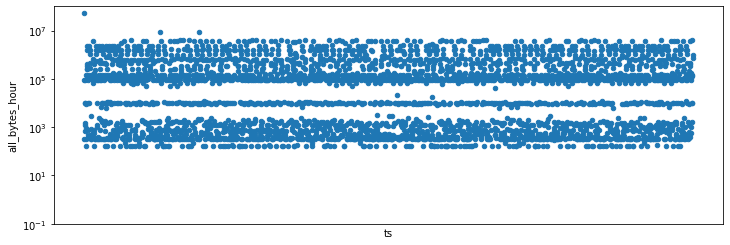

In [109]:
df_pkts.plot(x="ts", y="all_bytes_hour", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4), ylim=(0.1,1*100000000))

<AxesSubplot:xlabel='ts', ylabel='all_bytes_hour'>

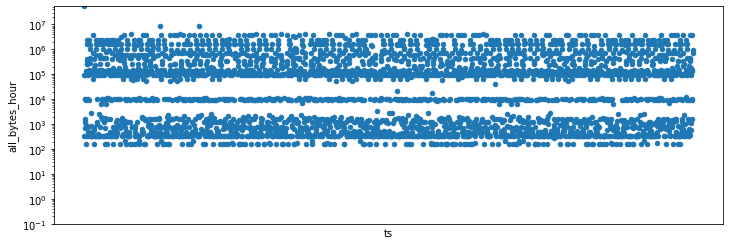

In [110]:
MAX_Y =  (df_pkts.loc[:, 'all_bytes_hour']).max()
df_pkts.plot(x="ts", y="all_bytes_hour", kind="scatter", logy=True, use_index=False, xticks=[], figsize=(12,4), ylim=(0.1,MAX_Y))

In [117]:
import numpy as np
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
packets = df_pkts.loc[:, 'all_pkts_hour']
print(packets)
np.isnan(packets)

0       89090
1           4
2          56
3          37
4          22
        ...  
3438       21
3439     7125
3440       98
3441      226
3442      171
Name: all_pkts_hour, Length: 3443, dtype: int64


0       False
1       False
2       False
3       False
4       False
        ...  
3438    False
3439    False
3440    False
3441    False
3442    False
Name: all_pkts_hour, Length: 3443, dtype: bool

In [118]:
fft = np.fft.rfft(packets)
np.isnan(packets)
fft

array([1665928.            +0.j        ,  119274.92107963-17517.41834254j,
         98635.15227613 +6524.3583698j , ...,
        203356.92488731+76173.68477231j,   50619.30002149-42873.63887405j,
         74236.16601779-30238.29697342j])

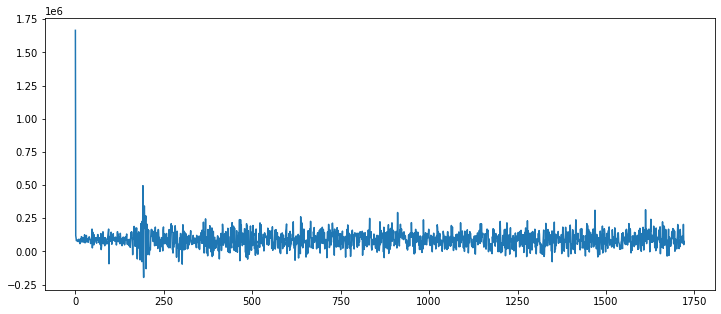

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(fft)
plt.show()

In [114]:
import numpy as np
bytesPre = df_pkts.loc[:, 'all_bytes_hour']
bytes = bytesPre.dropna()
print(bytes)
np.isnan(bytes)

0       53227854.0
1            319.0
2          91341.0
3           9837.0
4           1551.0
           ...    
3438        9734.0
3439     3914051.0
3440      134052.0
3441      936280.0
3442      700966.0
Name: all_bytes_hour, Length: 3439, dtype: float64


0       False
1       False
2       False
3       False
4       False
        ...  
3438    False
3439    False
3440    False
3441    False
3442    False
Name: all_bytes_hour, Length: 3439, dtype: bool

In [115]:
fft = np.fft.rfft(bytes)
np.isnan(bytes)
fft

array([1.29696404e+09       +0.j        ,
       8.58755474e+07-21387144.97534365j,
       5.78828943e+07 -4529995.47524808j, ...,
       4.87357327e+07-55585535.1018129j ,
       1.12224775e+08-23249066.02504464j,
       1.56308663e+07-22351969.85134528j])

C:\Users\Venator\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


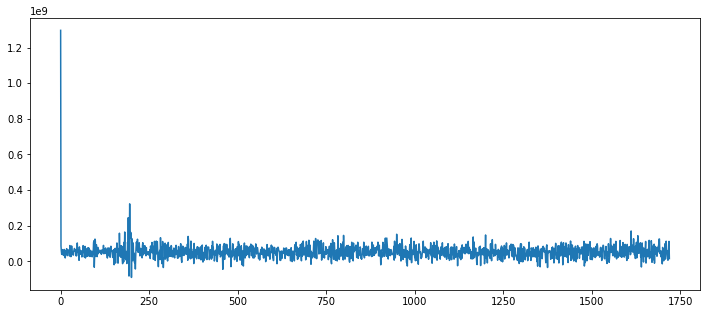

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(fft)
plt.show()